In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Marathon Finishing Times
source can be found [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.14-Visualization-With-Seaborn.ipynb#scrollTo=8P59vlYvyTxx)

In [ ]:
# download the dataset
# !curl -O https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv

In [ ]:
df = pd.read_csv("marathon-data.csv")
df.head(2)

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28


By default, Pandas loaded the time columns as Python strings (type `object`). We can see this by looking at the `dtypes` attribute of the DataFrame:

In [ ]:
df.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

Let's fix this by providing a converter for the times:

In [ ]:
import datetime

def coverting_times(s):
  h, m, s = map(int, s.split(":"))
  return datetime.timedelta(hours=h, minutes=m, seconds=s)

Let's do it

In [ ]:
# # for column split
# for i in df["split"]:
#   df["split"] = coverting_times(i)

# # for column final
# for i in df["final"]:
#   df["final"] = coverting_times(i)

df = pd.read_csv("marathon-data.csv",
                 converters={"split": coverting_times,
                             "final": coverting_times})

In [ ]:
print("Number of row    : {}".format(df.shape[0]))
print("Number of column : {}".format(df.shape[1]))

Number of row    : 37250
Number of column : 4


In [ ]:
df.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

That looks much better. For the purpose of our Seaborn plotting utilities, let's next add columns that give the times in seconds:

In [ ]:
def convert_to_seconds(dataframe, column_before, column_after):
  for i in range(0, len(column_before)):
    dataframe[column_after[i]] = dataframe[column_before[i]].astype(int)/1E9

In [ ]:
from_convert = ["split", "final"]
to_convert = ["split_sec", "final_sec"]

convert_to_seconds(df, from_convert, to_convert)
df.head(2)

,age,gender,split,final,split_sec,final_sec
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0


Let's start plotting by define class Visualization

In [ ]:
class Visualization:
  def __init__(self, dataframe):
    self.dataframe = dataframe
  
  def joint_plot(self, x_axis_data, y_axis_data, x_axis_min, x_axis_max, y_axis_min, y_axis_max):
    with sns.axes_style("white"):
      g = sns.jointplot(x=x_axis_data, y=y_axis_data, data=self.dataframe, kind="hex")
      g.ax_joint.plot(np.linspace(x_axis_min, x_axis_max),
                      np.linspace(y_axis_min, y_axis_max), ":k")
  
  def histogram(self, data):
    sns.distplot(self.dataframe[data], kde=False)
    plt.axvline(0, color="k", linestyle="--")
  
  def duo_sub_histogram(self, first_data, second_data):
    self.dataframe[[first_data, second_data]].plot.hist(subplots=True,
                                                        alpha = 0.6,
                                                        layout=(1, 2), 
                                                        figsize = (16, 5),
                                                        colormap = "cool")
  
  def duo_fract_by_gender_histogram(self):
    sns.kdeplot(self.dataframe.split_frac[self.dataframe.gender=="M"], label="men", shade="True")
    sns.kdeplot(self.dataframe.split_frac[self.dataframe.gender=="W"], label="woman", shade="True")
    plt.xlabel("split_frac")
  
  def grid_plot(self, list_of_variable, var_hue):
    g = sns.PairGrid(self.dataframe, vars=list_of_variable, hue=var_hue, palette="RdBu_r")
    g.map(plt.scatter, alpha=0.8)
    g.add_legend()
  
  def violin_plot(self, x_axis_data, y_axis_data):
    sns.violinplot(x_axis_data, 
                   y_axis_data, 
                   data=self.dataframe,
                   palette=["lightblue", "lightpink"])
  
  def violin_by_age(self, x_axis_data, y_axis_data, var_hue):
    men = (self.dataframe.gender == "M")
    women = (self.dataframe.gender == "W")

    with sns.axes_style(style=None):
      sns.violinplot(x_axis_data, y_axis_data, hue=var_hue, data=self.dataframe,
                     split=True, inner="quartile", palette=["lightblue", "lightpink"])
  
  def linear_regression_plot(self, x_axis_data, y_axis_data, var_col):
    g = sns.lmplot(x_axis_data, y_axis_data, col=var_col, data=self.dataframe,
                   markers=".", scatter_kws=dict(color="c"))
    g.map(plt.axhline, y=0.1, color="k", ls=":")

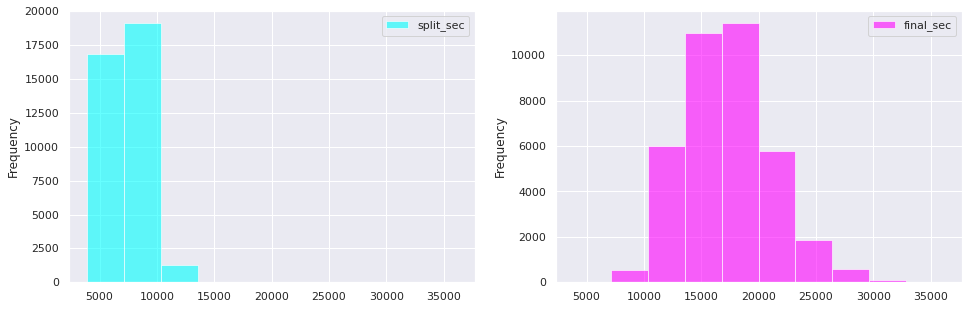

In [ ]:
Visualization(df).duo_sub_histogram("split_sec", "final_sec")

To get an idea of what the data looks like, we can plot a `jointplot` over the data

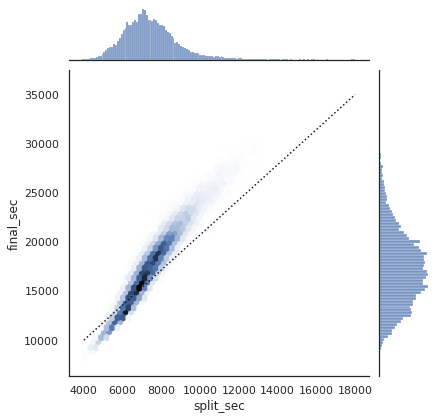

In [ ]:
Visualization(df).joint_plot("split_sec", "final_sec", 4000, 18000, 10000, 35000)

The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. 
_The fact that the distribution lies above this indicated (as you might expect) that most people slow down over the course of the marathon._
If you have run completely, you will know that those who do the opposite _-run faster during the second half of the race-_ are said to have "negative-split" the race.

Let's create another column, the split fraction, which measure the degree to which each runnin negative-splits or positive-splits the race:

In [ ]:
def split_fraction(dataframe):
  dataframe["split_frac"] = 1 - 2*dataframe["split_sec"]/dataframe["final_sec"]

In [ ]:
split_fraction(df)
df.head(2)

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0,-0.018756
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0,-0.026262


Where this split difference is less than zero, the person negative-split the race by that fraction. Let's do a distribution plot of this split fraction:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


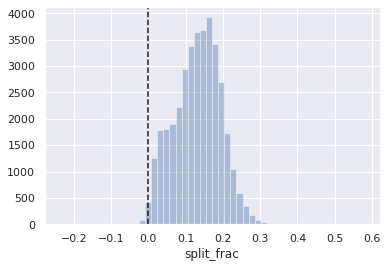

In [ ]:
Visualization(df).histogram("split_frac")

In [ ]:
sum(df.split_frac < 0)

251

Out of nearly 40,000 participants, there were only 250 participants who negative-split their marathon

Let's see whether there is any correlation between this split fraction and other variables. We'll do this using a `pairgrid`, which draws plots of all these correlations:

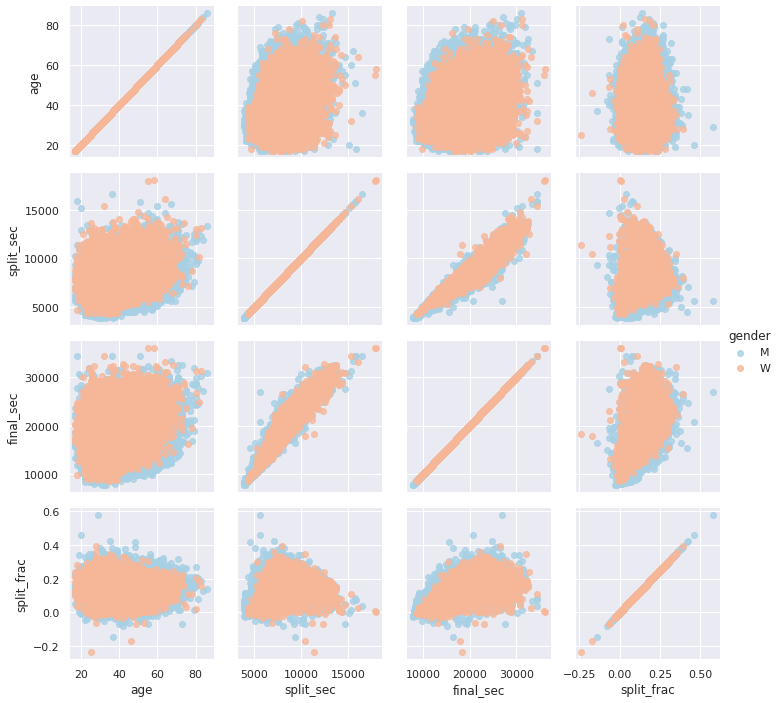

In [ ]:
vars = ["age", "split_sec", "final_sec", "split_frac"]
Visualization(df).grid_plot(vars, "gender")

It looks like the split fraction does not correlate particularly with age, but does correlate with the final time: faster runners tend to have closer to even splits on their marathon time.

The difference between men and women here is interesting. Let's look at histogram of splits fraction for these two groups:

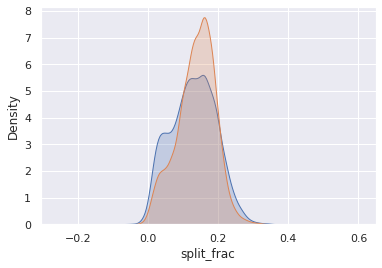

In [ ]:
Visualization(df).duo_fract_by_gender_histogram()

The interesting thing here is that there are many more man than women who are running close to an even split!
This  almost looks like some kind of _bimodal distribution_ among the man and women. 
Let's see if we can suss-out what's going on by looking at the distributions as a function of age.

A nice way to compare distributions is to use a _violin plot_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


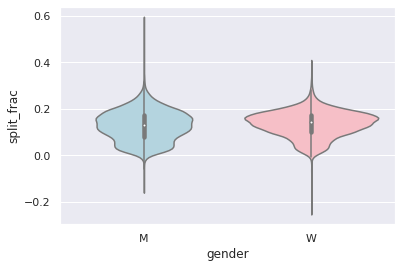

In [ ]:
Visualization(df).violin_plot("gender", "split_frac")

This is yet another way to compare the distributions between men and women.

Let's look a little deeper, and compare these violin plots as a function of age. We'll start by creating a new column in the array that specifies the decade of age that each person is in:

In [ ]:
df["age_decade"] = df.age.map(lambda age:10 * (age//10))    # convert age to specific decade
df.head(2)

,age,gender,split,final,split_sec,final_sec,split_frac,age_decade
0,33,M,0 days 01:05:38,0 days 02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,0 days 01:06:26,0 days 02:09:28,3986.0,7768.0,-0.026262,30


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


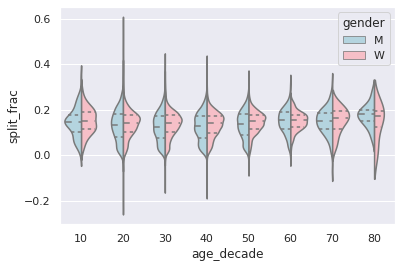

In [ ]:
Visualization(df).violin_by_age("age_decade", "split_frac", "gender")

Looking at this, we can see where the distributions of men and women differ: the split distributions of men in their 20s to 50s show a pronounched over-density toward lower splits when compared to woman of the same age (or of anu age, for that matter).

Also surprisingly, the 80-year-old women seem to outperform _everyone_ in terms of their split time. This is probably due to the fact that we are estimating the distribution from small numbers, as there are only a handful of runners in that range.

In [ ]:
(df.age > 80).sum()

7

Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We will use `regplot`, which will automatically fit a linear regression to the data:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


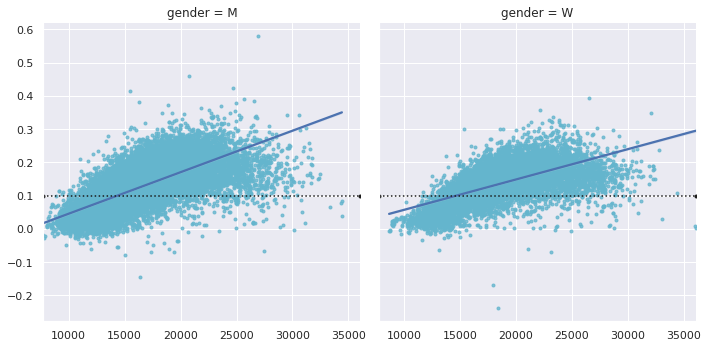

In [ ]:
Visualization(df).linear_regression_plot("final_sec", "split_frac", "gender")

Apparently, the people with fast splits are the elite runners who are finishing within ~15,000 seconds, or about 4 hours. People slower than that are much less likely to have a fast second splits.